# Gráficos de Série Histórica

Carregar arquivos para plotar séries históricas de parâmetros comparáveis com dados monitorados.
O objetivo é exemplificar a validade das simulações em relação ao observado.

In [2]:
import pandas as pd
from netCDF4 import Dataset
import numpy as np
#import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import seaborn as sns
import datetime as dt
from bisect import bisect_left
import math
%matplotlib inline

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before


## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem o arquivo da estação e nomes de rodadas.

In [52]:
directory = str('E:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
data  = ['01-09','07-24']
periodo = ['Verão', 'Inverno']
grade = 'd04'
#modelagens = ['andrade2015','pedruzzi2016','pedruzzi2016_nudge','silvajunior2009']
modelagens = ['andrade2015','pedruzzi2016','pedruzzi2016_nudge']
mod_var = ['T2']
est_var = ['temp','ur', 'wind_vel','wind_dir', 'prec']
spinup = 48
gmt = 3
date_index = 1

In [53]:
#DADOS ESTACAO
estacao     = 'SP_A726_PIRACICABA'
estcidade   = 'PIRACICABA'
estlat      = -22.703132
estlon      = -47.623317
altitude    = 566
est = pd.read_csv(directory+'arqEstacao/'+estacao+'.csv', delimiter=';')
est['datetime'] = (est['year'].map(str)+'-'+
                  est['month'].map(str)+'-'+
                  est['day'].map(str)+'-'+
                  est['hour'].map(str))
est['datetime'] = est['datetime'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d-%H'))
est.set_index('datetime',inplace=True)

#DADOS RODADAS
rodada=[]
for mod in modelagens:
    rodada.append(Dataset(directory+'arqWRF/'+mes[date_index]+
                        '/wrf_fnl_pira_'+mod+
                        '_'+mes[date_index]+
                        '/wrfout_'+grade+
                        '_2015-'+data[date_index]+'_00%3A00%3A00'))

#CROP DE DATA E COORDENADAS PARA POSICIONAR ESTAÇÃO
time_i   = dt.datetime.strptime(rodada[0].START_DATE,'%Y-%m-%d_%H:%M:%S')
lats     = rodada[0].variables['XLAT'][0,:,:]
longs    = rodada[0].variables['XLONG'][0,:,:]
if (estlat > np.amin(lats) and
    estlat < np.amax(lats) and
    estlon > np.amin(longs)and
    estlon < np.amax(longs)):                
    esty     = lats[:,0].tolist().index(takeClosest(lats[:,0],estlat))     #index Lat da estação no domínio
    estx     = longs[0,:].tolist().index(takeClosest(longs[0,:],estlon))

## Carregar DFs com dados da estação e de modelagens 

In [54]:
# Iniciar DF com dados da Estação, usando est_param
tempdf    = pd.DataFrame(est[time_i:time_i+dt.timedelta(hours=rodada[0].dimensions['Time'].size-1)]['temp'])
urdf      = pd.DataFrame(est[time_i:time_i+dt.timedelta(hours=rodada[0].dimensions['Time'].size-1)]['ur'])
precdf    = pd.DataFrame(est[time_i:time_i+dt.timedelta(hours=rodada[0].dimensions['Time'].size-1)]['prec'])
windveldf = pd.DataFrame(est[time_i:time_i+dt.timedelta(hours=rodada[0].dimensions['Time'].size-1)]['wind_vel'])
winddirdf = pd.DataFrame(est[time_i:time_i+dt.timedelta(hours=rodada[0].dimensions['Time'].size-1)]['wind_dir'])
urdf['press']      = pd.DataFrame(est[time_i:time_i+dt.timedelta(hours=rodada[0].dimensions['Time'].size-1)]['press'])



# Tratar valores 0 
tempdf  = tempdf.applymap(lambda x: np.nan if x == -999 else x)
urdf    = urdf.applymap(lambda x: np.nan if x == -999 else x)
precdf  = precdf.applymap(lambda x: np.nan if x == -999 else x)
windveldf = windveldf.applymap(lambda x: np.nan if x == -999 else x)
winddirdf = winddirdf.applymap(lambda x: np.nan if x == -999 else x)

# CONVERSÕES
# converter umidade da estação para umidade relativa 
# equation extract from Meteorology for Scientists and Engineers 3rd edition 2011 : Roland Stull
urdf['svp']        = tempdf['temp'].apply(lambda x: (0.611*math.exp(5423*((1/273.15)-(1/x))))) #saturation vapor pressure = es   
urdf['vaporpress'] = urdf.apply(lambda row: row.ur * row.svp/100, axis=1)                      # vapor pressure = e
# umidade específica [g/kg]
urdf['hum']        = urdf.apply(lambda row: 1000*(0.622*row.vaporpress/((row.press/10)-(row.vaporpress*0.378))), axis=1) # umidade específica [g/kg]
urdf.drop(columns=['ur','press','svp','vaporpress'], inplace=True)

# Converter dados da estação em -180 a 180
winddirdf = winddirdf.applymap(lambda x: x - 360 if x > 180 else x)

# MODELAGENS 
# Buscar dados das modelagens, usando mod_param
for i in range(0,len(modelagens)):
# TEMP
    tempdf[modelagens[i]] = pd.Series(rodada[i].variables['T2'][:,esty,estx], index=tempdf.index)
# UMID
    urdf[modelagens[i]]   = pd.Series(rodada[i].variables['Q2'][:,esty,estx], index=urdf.index)
    urdf[modelagens[i]]   = urdf[modelagens[i]].apply(lambda x: 1000*x)
# VENTOS   
    u10 = 'U10'+modelagens[i]
    v10 = 'V10'+modelagens[i]
    # Calcula Velocidade
    windveldf[u10] = pd.Series(rodada[i].variables['U10'][:,esty,estx], index=windveldf.index)
    windveldf[v10] = pd.Series(rodada[i].variables['V10'][:,esty,estx], index=windveldf.index)
    windveldf[modelagens[i]] = ((windveldf[u10]**2 + windveldf[v10]**2)**0.5)
    windveldf.drop(columns=[u10,v10], inplace=True)
    # Calcula Direção
    winddirdf[u10] = pd.Series(rodada[i].variables['U10'][:,esty,estx], index=winddirdf.index)
    winddirdf[v10] = pd.Series(rodada[i].variables['V10'][:,esty,estx], index=winddirdf.index) 
    direc = []
    for row in range(0,len(winddirdf)):
        if winddirdf[u10].iloc[row] > 0:
            d = 90 - ((180.0/np.pi) * math.atan(winddirdf[v10].iloc[row]/winddirdf[u10].iloc[row])) + 180
            if d > 180:
                d = d - 360
                direc.append(d)
            else:
                direc.append(d)
        else:
            d = 90 - ((180.0/np.pi) * math.atan(winddirdf[v10].iloc[row]/winddirdf[u10].iloc[row]))
            if d > 180:
                d = d - 360
                direc.append(d)
            else:
                direc.append(d)
    winddirdf[modelagens[i]] = pd.Series(direc, index=winddirdf.index)
    winddirdf.drop(columns=[u10,v10], inplace=True)
      
# AJUSTES
# Ajustar Temperatura para Celsius
tempdf  = tempdf.applymap(lambda x: x-273.15)

# RENOMEAR COLUNAS DA ESTACAO
tempdf.rename(columns={'temp': estacao}, inplace=True)
urdf.rename(columns={'hum': estacao}, inplace=True)
windveldf.rename(columns={'wind_vel': estacao}, inplace=True)
winddirdf.rename(columns={'wind_dir': estacao}, inplace=True)


## **Crop e ajuste de horário local**
### Datas da simulação

In [55]:
tempdf.drop(tempdf.index[:spinup] | tempdf.index[spinup+24*7:], inplace=True)
urdf.drop(urdf.index[:spinup] | urdf.index[spinup+24*7:], inplace=True)
precdf.drop(precdf.index[:spinup] | precdf.index[spinup+24*7:], inplace=True)
windveldf.drop(windveldf.index[:spinup] | windveldf.index[spinup+24*7:], inplace=True)
winddirdf.drop(winddirdf.index[:spinup] | winddirdf.index[spinup+24*7:], inplace=True)

### Ajuste GMT

In [56]:
tempdf.index -= pd.Timedelta(gmt,'h')
urdf.index   -= pd.Timedelta(gmt,'h')
precdf.index -= pd.Timedelta(gmt,'h')
windveldf.index -= pd.Timedelta(gmt,'h')
winddirdf.index -= pd.Timedelta(gmt,'h')

## Plot 



### Série Histórica

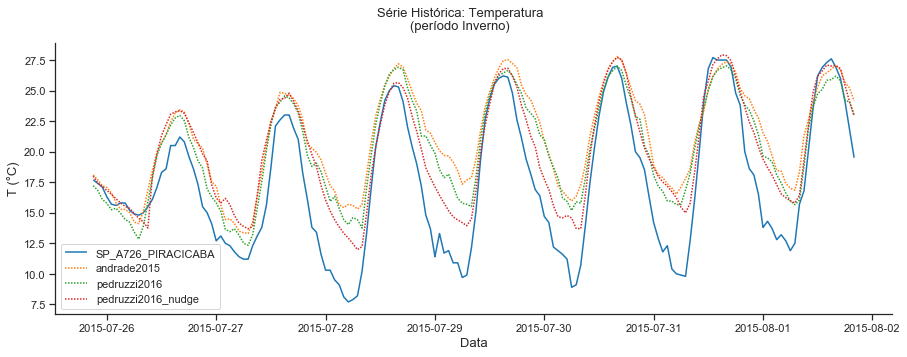

In [57]:
# Temperatura
stackdf = tempdf.stack()
stackdf = pd.DataFrame(stackdf.reset_index())
stackdf.columns = ['dt','rodadas','T']
fig, ax = plt.subplots(ncols=1, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
fig.suptitle('Série Histórica: Temperatura'+
             '\n''(período '+periodo[date_index]+')', fontsize=13)
sns.lineplot(x=stackdf['dt'], y=stackdf['T'], hue=stackdf['rodadas'],palette='tab10', 
             style=stackdf['rodadas'],dashes=[(1,0),(1,1),(1,1),(1,1),(1,1)], legend=False)
sns.set(style='ticks')
sns.despine()
ax.set_ylabel('T (°C)', fontsize=13)
ax.set_xlabel('Data', fontsize=13)
ax.legend(stackdf['rodadas'])
#ax.set_ylim(20,36)
#ax.locator_params('x',nbins=23)

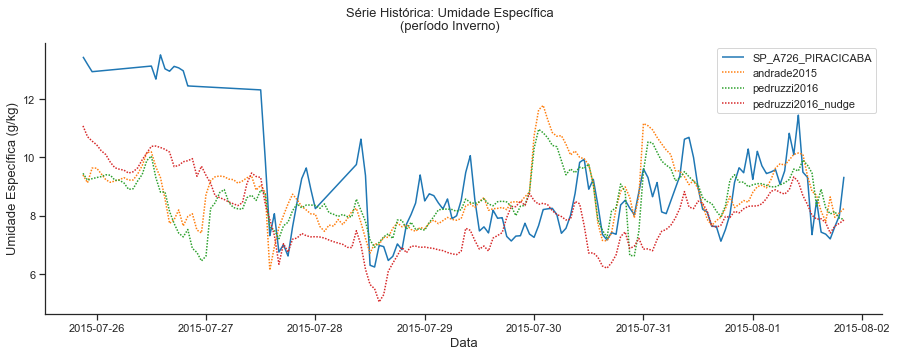

In [58]:
# Umidade Específica
stackdf = urdf.stack()
stackdf = pd.DataFrame(stackdf.reset_index())
stackdf.columns = ['dt','rodadas','ur']
fig, ax = plt.subplots(ncols=1, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
fig.suptitle('Série Histórica: Umidade Específica'+
             '\n''(período '+periodo[date_index]+')', fontsize=13)
sns.lineplot(x=stackdf['dt'], y=stackdf['ur'], hue=stackdf['rodadas'],palette='tab10', 
             style=stackdf['rodadas'],dashes=[(1,0),(1,1),(1,1),(1,1),(1,1)],legend=False)
sns.set(style='ticks')
sns.despine()
ax.set_ylabel('Umidade Específica (g/kg)', fontsize=13)
ax.set_xlabel('Data', fontsize=13)
ax.legend(stackdf['rodadas'])
#ax.set_ylim(20,36)
#ax.locator_params('x',nbins=23)

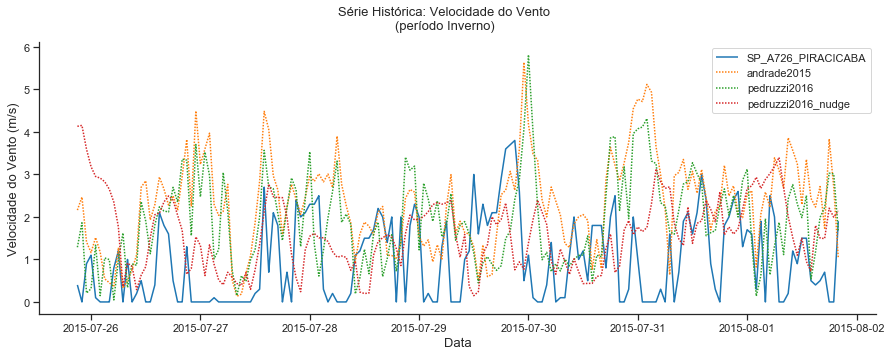

In [59]:
# Velocidade do Vento
stackdf = windveldf.stack()
stackdf = pd.DataFrame(stackdf.reset_index())
stackdf.columns = ['dt','rodadas','windvel']
fig, ax = plt.subplots(ncols=1, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
fig.suptitle('Série Histórica: Velocidade do Vento'+
             '\n''(período '+periodo[date_index]+')', fontsize=13)
sns.lineplot(x=stackdf['dt'], y=stackdf['windvel'], hue=stackdf['rodadas'],palette='tab10', 
             style=stackdf['rodadas'],dashes=[(1,0),(1,1),(1,1),(1,1),(1,1)],legend=False)
sns.set(style='ticks')
sns.despine()
ax.set_ylabel('Velocidade do Vento (m/s)', fontsize=13)
ax.set_xlabel('Data', fontsize=13)
ax.legend(stackdf['rodadas'])
#ax.set_ylim(20,36)
#ax.locator_params('x',nbins=23)

## Precipitação

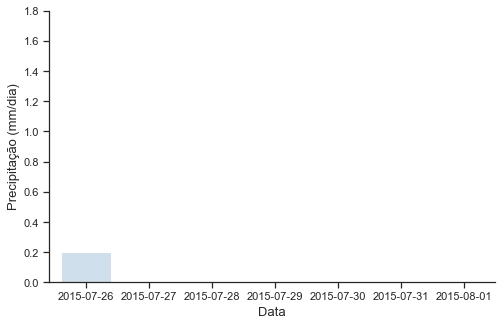

In [60]:
fig, ax = plt.subplots(ncols=1, figsize=(8,5))
sns.barplot(y=precdf['prec'], x=precdf.index.strftime('%Y-%m-%d'), estimator=sum, palette='Blues', ax=ax, ci=None)
ax.set_ylabel('Precipitação (mm/dia)', fontsize=13)
ax.set_xlabel('Data', fontsize=13)
ax.set_ylim(bottom=0.0, top=1.8)
ax.set_xlim(left=0.4)
#sns.scatterplot(y=precdf['prec'], x=precdf.index.hour, ci=None, color='gold')
sns.despine()

In [63]:
a = precdf[precdf.index>=('2015-07-26')]
a = a[a.index<('2015-07-27')]

In [64]:
a.prec.sum()

0.2

### Regressão linear

NameError: name 'tempdf' is not defined

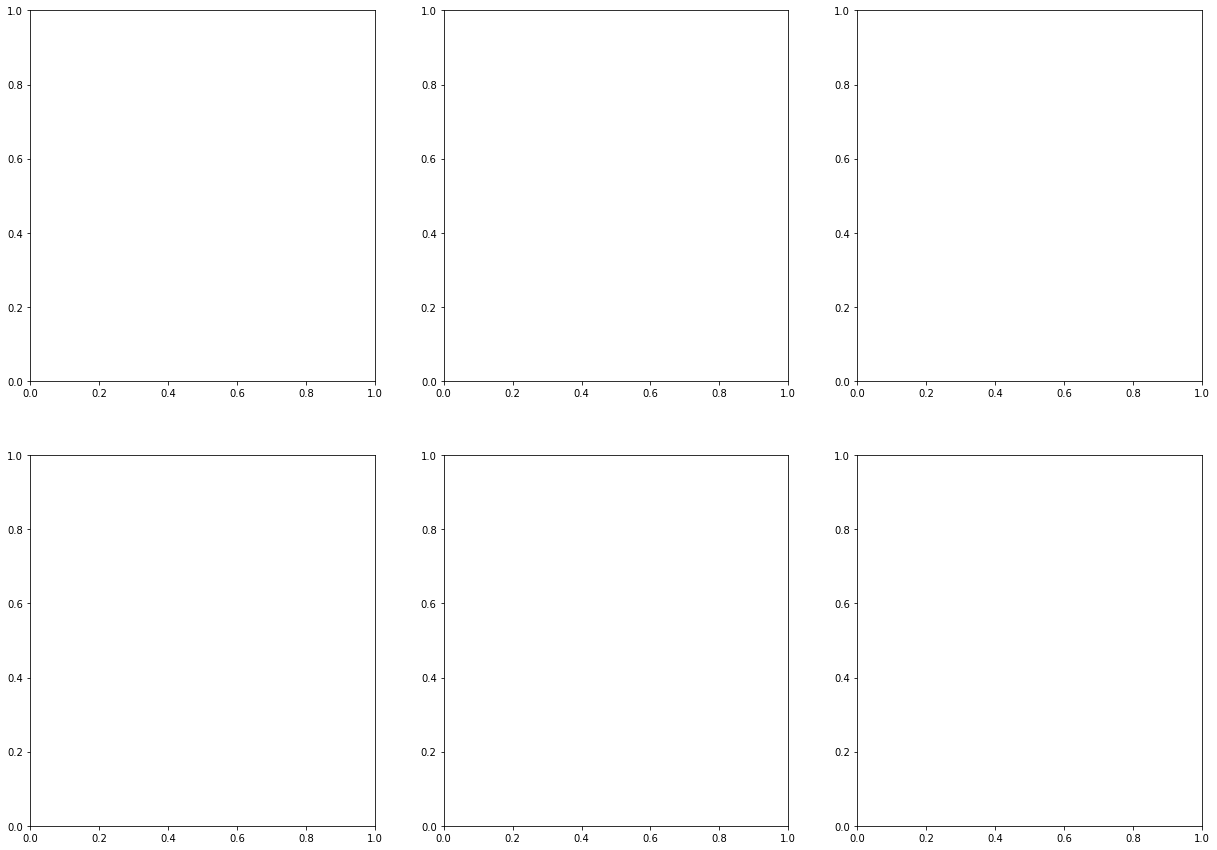

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=len(modelagens), figsize=(21,15))
c = ['b','r','g']
for i in range(0,len(modelagens)):
    sns.regplot(tempdf['temp'],tempdf[modelagens[i]], ax=axes[0,i], color=c[i], label='TESTE')
    sns.regplot(urdf['hum'], urdf[modelagens[i]], ax=axes[1,i], color=c[i])

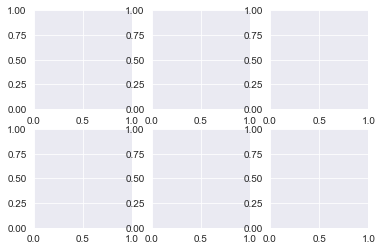

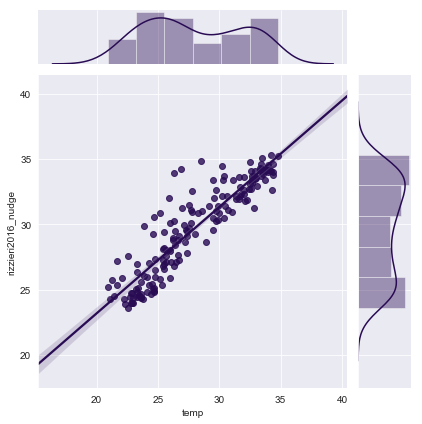

In [53]:
fig, axes = plt.subplots(2,len(modelagens))
sns.jointplot(tempdf['temp'],tempdf[modelagens[2]],kind='reg')

Text(0,0.5,'Temperatura')

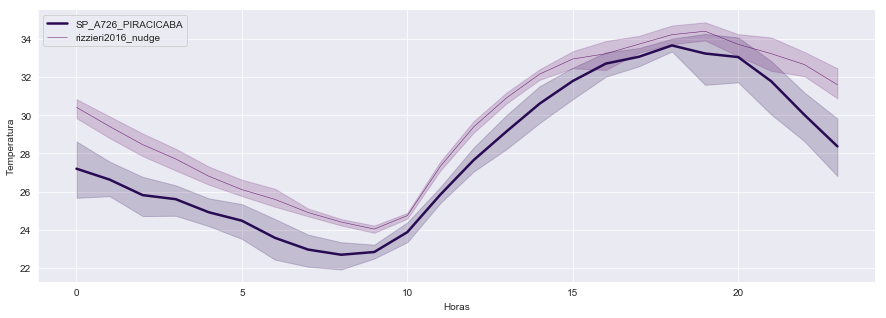

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
sns.despine()
sns.set_style(style='darkgrid')
sns.set_palette('inferno')
fig =  sns.lineplot(x=tempdf.index.hour.values, y=tempdf['temp'], linewidth=2.5,legend='brief', label=estacao)
#sns.lineplot(x=tempdf.index.hour.values, y=tempdf[modelagens[0]], palette="inferno", linewidth=.5)
#sns.lineplot(x=tempdf.index.hour.values, y=tempdf[modelagens[1]], palette="inferno", linewidth=.5)
sns.lineplot(x=tempdf.index.hour.values, y=tempdf[modelagens[2]], linewidth=.5, label=modelagens[2])
ax.set_xlabel('Horas')
ax.set_ylabel('Temperatura')

KeyError: 'prec'

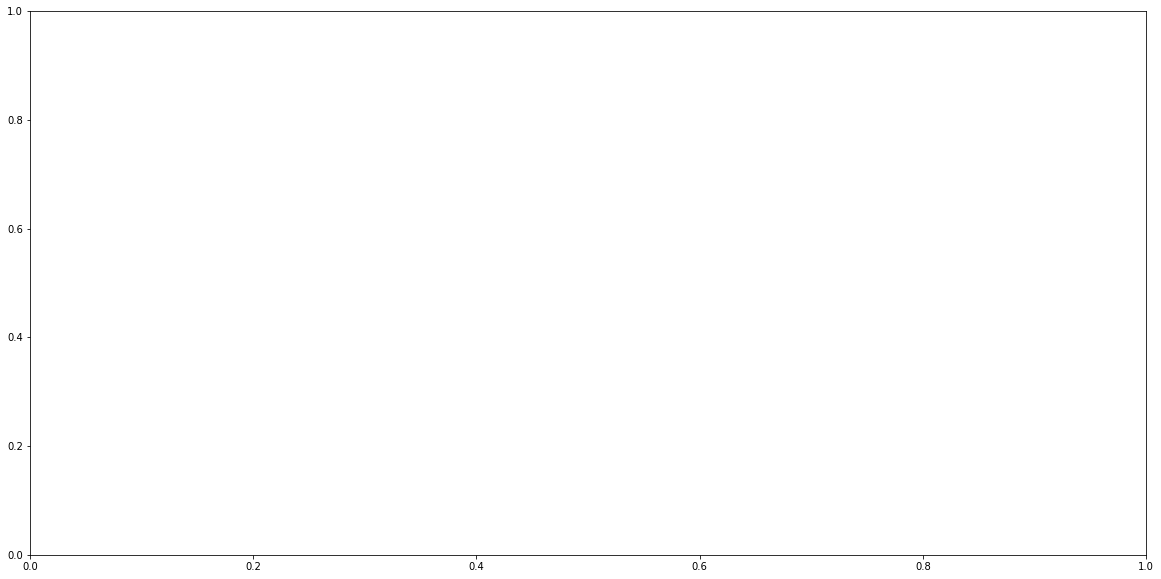

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
fig =  sns.lineplot(x=urdf.index.hour.values, y=urdf['prec'], palette="g", linewidth=2.5)
#sns.lineplot(x=urdf.index.hour.values, y=urdf[modelagens[0]], palette="tab10", linewidth=.5)
#sns.lineplot(x=urdf.index.hour.values, y=urdf[modelagens[1]], palette="tab10", linewidth=.5)
sns.lineplot(x=urdf.index.hour.values, y=urdf[modelagens[2]], palette="coolwarm", linewidth=.5)
ax.set_xlabel('horas')

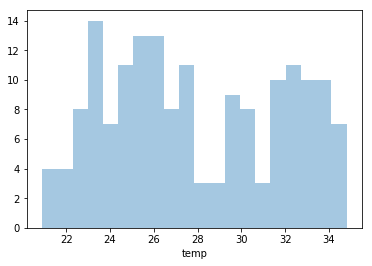

In [11]:
sns.distplot(tempdf['temp'].dropna(), kde=False, bins = 20)

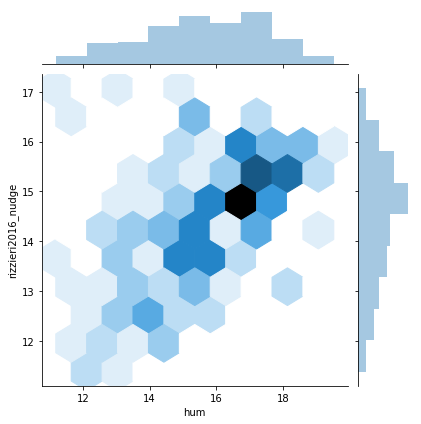

In [55]:
sns.jointplot(x=urdf['hum'], y=urdf[modelagens[2]], data=urdf, kind='hex')

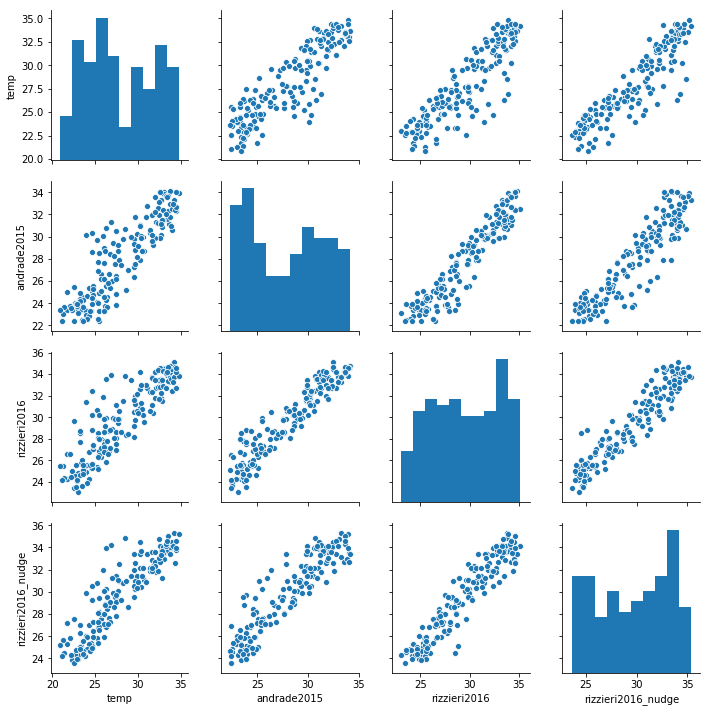

In [12]:
sns.pairplot(tempdf.dropna(), palette="coolwarm")

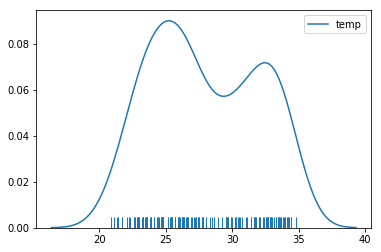

In [13]:
sns.rugplot(tempdf['temp'].dropna())
sns.kdeplot(tempdf['temp'].dropna())

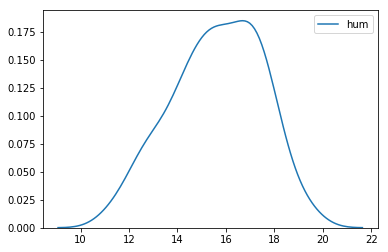

In [14]:
sns.kdeplot(urdf['hum'].dropna())

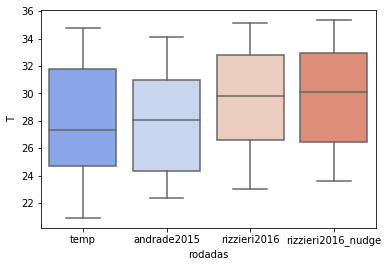

In [82]:
stackdf = tempdf.stack()
stackdf = pd.DataFrame(stackdf.reset_index())
stackdf.columns = ['dt','rodadas','T']
sns.boxplot(x=stackdf['rodadas'], y=stackdf['T'], palette="coolwarm")

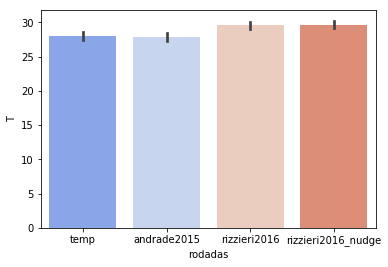

In [16]:
sns.barplot(x=stackdf['rodadas'], y=stackdf['T'], palette="coolwarm")

In [80]:
rodada[0].dimensions

OrderedDict([('Time',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 223),
             ('DateStrLen',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'DateStrLen', size = 19),
             ('west_east',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east', size = 114),
             ('south_north',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north', size = 114),
             ('bottom_top',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top', size = 31),
             ('bottom_top_stag',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top_stag', size = 32),
             ('soil_layers_stag',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'soil_layers_stag', size = 4),
             ('west_east_stag',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east_stag', size = 115),
             ('south_north_stag',
              <class 'netCDF4

In [24]:
tempdf.stack().rename()

datetime                               
2015-01-09 00:00:00  temp                  24.900000
                     andrade2015           21.780145
                     rizzieri2016          21.780145
                     rizzieri2016_nudge    21.780145
2015-01-09 01:00:00  temp                  25.000000
                     andrade2015           24.124658
                     rizzieri2016          24.136835
                     rizzieri2016_nudge    24.168268
2015-01-09 02:00:00  temp                  24.000000
                     andrade2015           23.583978
                     rizzieri2016          23.354669
                     rizzieri2016_nudge    23.359979
2015-01-09 03:00:00  temp                  22.800000
                     andrade2015           22.602014
                     rizzieri2016          22.277673
                     rizzieri2016_nudge    22.611200
2015-01-09 04:00:00  temp                  21.900000
                     andrade2015           21.944940
      